In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import regionmask
import xesmf as xe
import cmocean

import sys
sys.path.append('../')
import utils
import plotting

import math

# Import Data and Count mortalities

In [2]:
ds_o3 = xr.open_zarr('./final_data/o3_mortalities.zarr')
ds_PM = xr.open_zarr('./final_data/pm_mortalities.zarr')

In [3]:
for ids in ['mean','low','high']:
    print('ozone')
    print('nonuc', ids, ds_o3.sel(model_name = 'nonuc_NA')[f'Δmortality_{ids}'].sum().values)
    print('nonuc_coal', ids, ds_o3.sel(model_name = 'nonuc_coal_NA')[f'Δmortality_{ids}'].sum().values)
    print('PM25')
    print('nonuc', ids, ds_PM.sel( model_name = 'nonuc_NA')[f'Δmortality_{ids}'].sum().values)
    print('nonuc_coal', ids, ds_PM.sel(model_name = 'nonuc_coal_NA')[f'Δmortality_{ids}'].sum().values)

ozone
nonuc mean 1443.7991
nonuc_coal mean 211.3508
PM25
nonuc mean 7759.334170601242
nonuc_coal mean 8170.545926159869
ozone
nonuc low 725.4733
nonuc_coal low 106.1985
PM25
nonuc low 5840.992828150796
nonuc_coal low 6399.964733871637
ozone
nonuc high 2859.5615
nonuc_coal high 418.5973
PM25
nonuc high 9755.066382205296
nonuc_coal high 10022.292768548099


## monetization of the health impacts


In [4]:
#convert from 2006 dollars to 2007
conversion = 1.0285

In [5]:
VSL = 7.4E6
print('nonuc, O3: ', "{:e}".format((ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_NA').sum()*VSL*conversion).values))
print('nonuc/coal, O3: ',"{:e}".format((ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA').sum()*VSL*conversion).values))
print('nonuc, PM: ',"{:e}".format((ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_NA').sum()*VSL*conversion).values))
print('nonuc/coal, PM: ',"{:e}".format((ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA').sum()*VSL*conversion).values))

nonuc, O3:  1.098861e+10
nonuc/coal, O3:  1.608570e+09
nonuc, PM:  5.905552e+10
nonuc/coal, PM:  6.218521e+10


# Plot

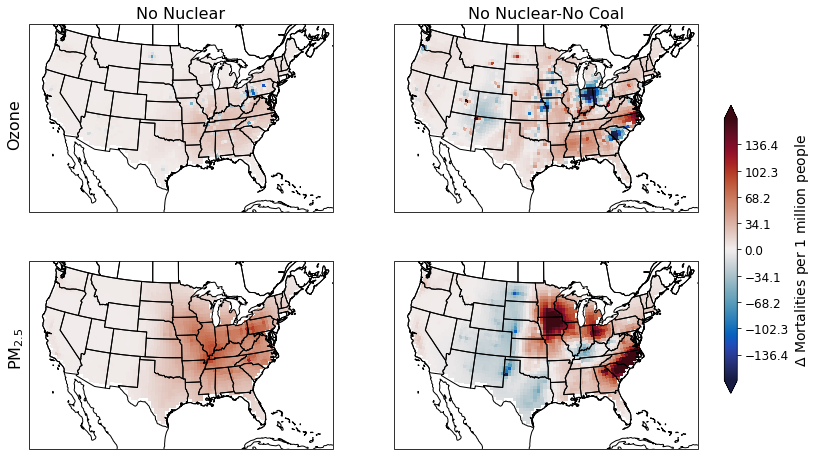

In [6]:
fig = plt.figure(figsize=[12,8])
###O3 No Nuclear plot ###
lev = np.squeeze(np.arange(-170,170.1,.1))
cmap = cmocean.cm.balance
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel( model_name = 'nonuc_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3.set_title('No Nuclear', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent([-120,-70,20,50])

###O3 No Nuclear No Coal plot ###

ax_o3_coal = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3_coal,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_coal.set_title('No Nuclear-No Coal', fontsize = 16)
ax_o3_coal.add_feature(cfeat.STATES)
ax_o3_coal.coastlines()
ax_o3_coal.set_extent([-120,-70,20,50])
###PM No Nuclear plot ###

ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent([-120,-70,20,50])
###PM No Nuclear No Coal plot ###
ax_pm_coal = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm_coal, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_coal.set_title(r' ', fontsize = 16)
ax_pm_coal.add_feature(cfeat.STATES)
ax_pm_coal.coastlines()
ax_pm_coal.set_extent([-120,-70,20,50])


cbar_ax = fig.add_axes([.93, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')

fig.text(.1,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.1,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

plt.savefig('./Figures/mortalities.png', bbox_inches = 'tight', dpi = 150)

In [12]:
(ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')-
 ds_o3['Δmortality_mean'].sel(model_name = 'normal_NA')).sum().values

array(211.3508, dtype=float32)

In [16]:
(ds_o3['SpeciesConc_O3'].sel(model_name = 'nonuc_coal_NA')-
 ds_o3['SpeciesConc_O3'].sel(model_name = 'normal_NA')).mean().values*1e9

0.26682611675710177